In [ ]:
%matplotlib inline


Finetuning Torchvision Models
=============================

**Author:** `Nathan Inkawhich <https://github.com/inkawhich>`__




**Importing Libraries**

In [ ]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
import pickle

PyTorch Version:  1.11.0+cu113
Torchvision Version:  0.12.0+cu113


**Mounting google drive and unziping data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/train.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/6/396713.jpg      
  inflating: train/6/396724.jpg      
  inflating: train/6/396725.jpg      
  inflating: train/6/396757.jpg      
  inflating: train/6/396766.jpg      
  inflating: train/6/396776.jpg      
  inflating: train/6/396786.jpg      
  inflating: train/6/396789.jpg      
  inflating: train/6/39679.jpg       
  inflating: train/6/396797.jpg      
  inflating: train/6/396807.jpg      
  inflating: train/6/396857.jpg      
  inflating: train/6/396873.jpg      
  inflating: train/6/396895.jpg      
  inflating: train/6/396907.jpg      
  inflating: train/6/396911.jpg      
  inflating: train/6/396917.jpg      
  inflating: train/6/396920.jpg      
  inflating: train/6/396949.jpg      
  inflating: train/6/396952.jpg      
  inflating: train/6/39696.jpg       
  inflating: train/6/396961.jpg      
  inflating: train/6/396971.jpg      
  inflating: train/6/396995.jpg      
  inflating: train/6/397039.jpg      

**some parameters**

In [ ]:
data_dir = "/content"
model_name = "resnet"
num_classes = 7
batch_size = 256
num_epochs = 10
feature_extract = False

**Training function**

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False,using_check_points=False,PATH="/content/drive/MyDrive/"):
    since = time.time()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  
    map_location=torch.device(device)

    val_loss_list=[]
    val_acc_history = []
    train_loss_list=[]
    train_acc_list=[]
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0 
    epoch=0
    
# loading checkpoints if neede
    if using_check_points:
       checkpoint = torch.load(PATH+"model.pt",map_location=map_location)
       model.load_state_dict(checkpoint['model_state_dict'])
       optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
       epoch = checkpoint['epoch']
       epoch_loss = checkpoint['loss']
       val_loss_list=checkpoint['val_loss']
       val_acc_history = checkpoint['val_acc']
       train_loss_list=checkpoint["train_loss"]
       train_acc_list=checkpoint['train_acc']
       
      
 
       
      

    while epoch <num_epochs:
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        epoch=epoch+1

        # Each epoch has a training and validation phase
        for phase in ['train',"val"]:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_list.append(epoch_loss)
                print("valdiation accuracy",epoch_acc)
            if phase =="train":
              train_acc_list.append(epoch_acc)
              train_loss_list.append(epoch_loss)
            
            #Saving checkpoints
            
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            'val_loss': val_loss_list,
            'val_acc': val_acc_history,
            'train_loss': train_loss_list,
            'train_acc': train_acc_list,
            }, PATH+"model.pt")
            

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history,val_loss_list,train_loss_list,train_acc_list,best_model_wts

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = True

Initialize and Reshape the Networks
-----------------------------------



In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Loading and transformung data
---------






In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


**Splitting data**

In [ ]:
l=len(image_datasets["train"])
train_set, val_set = torch.utils.data.random_split(image_datasets["train"], [int(l*.80)+1, int(l*.20)])

In [ ]:
train=torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val=torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
dataloaders_dict={"train":train,"val":val}

Create the Optimizer
--------------------






In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

Run Training and Validation Step
--------------------------------

Finally, the last step is to setup the loss for the model, then run the
training and validation function for the set number of epochs. Notice,
depending on the number of epochs this step may take a while on a CPU.
Also, the default learning rate is not optimal for all of the models, so
to achieve maximum accuracy it would be necessary to tune for each model
separately.




In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntzzropyLoss()

# Train and evaluate
model_ft, hist, val_loss_list,train_loss_list,train_acc_list,best_model_wts= train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"),using_check_points=True,devic="cpu")

Epoch 23/39
----------


**accuracy curve**

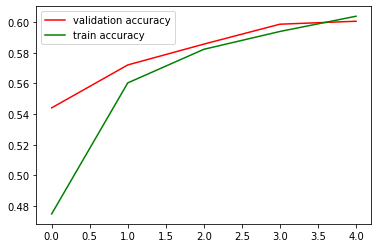

In [ ]:
import matplotlib.pyplot as plt
hist=torch.as_tensor(hist)
plt.plot(hist,color="r",label="validation accuracy")
plt.plot(torch.as_tensor(train_acc_list),color="g",label="train accuracy")
plt.legend()
plt.show()

**loss curve**

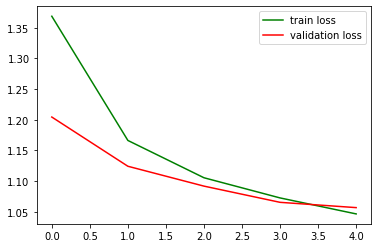

In [ ]:
plt.plot(torch.as_tensor(train_loss_list),color="g",label="train loss")
plt.plot(torch.as_tensor(val_loss_list),color="r",label="validation loss")
plt.legend()
plt.show()

**Prediction function**

In [ ]:
def prediction(model,dataloader):
  for inputs,labels in dataloader:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    inputs = inputs.to(device)
    labels = labels.to(device)
    model=model.to(device)
    outputs = model(inputs)
  _, preds = torch.max(outputs, 1)
  return preds,labels
                        



In [ ]:
preds,labels= prediction(model_ft,dataloaders_dict["val"])

**Accuracy**

In [ ]:
def accuracy_report(labels,preds):
  import itertools
  import numpy as np
  import matplotlib.pyplot as plt
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import precision_score
  from sklearn.metrics import f1_score
  from sklearn.metrics import recall_score

  cm=confusion_matrix(labels.cpu().numpy(), preds.cpu().numpy())
  cm=cm.astype(int)
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
  plt.title("confusiom_matrix")
  plt.colorbar()
  tick_marks = np.arange(7)
  plt.xticks(tick_marks, [0,1,2,3,4,5,6], rotation=45)
  plt.yticks(tick_marks, [0,1,2,3,4,5,6])
  fmt = '.2f' 
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
  
  precision_score=precision_score(labels.cpu().numpy(), preds.cpu().numpy(), average=None)
  print("Presion Score is",precision_score)

  f1_score=f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average=None)
  print("f1_score is  ", f1_score)

  recall_score=recall_score(labels.cpu().numpy(), preds.cpu().numpy(), average=None)
  print("recall_score is  ", recall_score)







/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Presion Score is [0.175      0.11363636 0.         0.11570248 0.1        0.
 0.19354839]
f1_score is   [0.16666667 0.11111111 0.         0.17610063 0.07407407 0.
 0.16438356]
recall_score is   [0.15909091 0.10869565 0.         0.36842105 0.05882353 0.
 0.14285714]


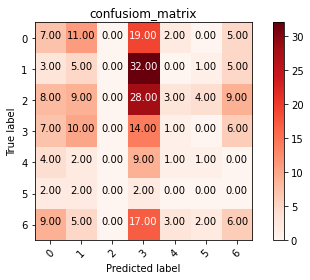

In [ ]:
accuracy_report(labels,preds)